# Filter out tracks based on criteria

## Set filtering parameters below

In [1]:
# Drop tracks shorter than this length (in frames)
threshold_length = 3 

# Drop tracks in which the peak intensity happens at or before this frame
peak_cutoff = 3 

# This is the minimum intensity value that a specific channel within a track must achieve to be considered positive for that channel.
threshold_intensity_channel_1 = 160 
threshold_intensity_channel_2 = 160 

 # set this to false if you don't want to classify by apical, lateral, basal; THIS DOESN'T WORK YET WHEN SET TO FALSE
membrane_regions_exist = True

# set default channel names (optionally adjust)

channel1_name = 'channel 1'
channel2_name = 'channel 2'
channel3_name = 'channel 3'


## Import Packages

In [2]:
import pandas as pd 
import numpy as np 
import sys
sys.path.append('../src/')
from filters import Track, create_tracks_from_dataframe, drop_short_tracks
from filters import drop_early_peak_tracks, drop_last_frame_peak_tracks, drop_tracks_below_intensity
from filters import plot_z_sum, allocate_membrane_regions, plot_z_sum_bd
import napari
import zarr
import dask.array as da
import os

Do not change the code in the cell below 

In [3]:
# This assumes that your notebook is inside 'Jupyter Notebooks', which is at the same level as 'test_data'
base_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), '..', 'movie_data')

zarr_directory = 'zarr_file/all_channels_data'
zarr_full_path = os.path.join(base_dir, zarr_directory)

input_directory = 'datasets'
input_file_name = 'track_df_cleaned_final_full.pkl'
input_directory_full = os.path.join(base_dir,input_directory, input_file_name)

output_directory = 'datasets'
output_file_name = 'filtered_tracks_final.pkl'
output_directory_full = os.path.join(base_dir,output_directory, output_file_name)

In [4]:
# open tracks and movie
track_df = pd.read_pickle(input_directory_full)

z2 = zarr.open(zarr_full_path, mode='r')


In [5]:
tracks = create_tracks_from_dataframe(df = track_df, intensities_col_name = ['c3_peak_mean', 'c2_peak_mean', 'c1_peak_mean'], 
track_id_col_name = 'track_id', frame_col_name = 'frame', coords = ['mu_x', 'mu_y', 'mu_z'])

In [6]:
# Create DataFrame from Track instances
tracks_data = {
    'track_id': [track.track_id.values[0] for track in tracks],
    'track_length': [track.track_length for track in tracks],
    'track_start': [track.track_start for track in tracks],
    'track_end': [track.track_end for track in tracks],
    'c3_peak': [track.peak_intensities[0] for track in tracks],
    'c2_peak': [track.peak_intensities[1] for track in tracks],
    'c1_peak': [track.peak_intensities[2] for track in tracks],
    'c3_peak_frame': [track.peak_intensity_frames[0] for track in tracks],
    'c2_peak_frame': [track.peak_intensity_frames[1] for track in tracks],
    'c1_peak_frame': [track.peak_intensity_frames[2] for track in tracks],
    'mean_displacement': [track.mean_displacement_track for track in tracks],
    'mean_z': [track.mean_z_value for track in tracks],
    'mean_z_displacement': [track.mean_z_displacement for track in tracks], 
    'max_radius_from_origin': [track.max_radius_from_origin for track in tracks], 
    'max_distance_between_two_points': [track.max_distance_between_two_points for track in tracks], 
    'C3_adjusted_voxel_sum_positive': [track.adjusted_voxel_sum[0] for track in tracks],
    'C2_adjusted_voxel_sum_positive': [track.adjusted_voxel_sum[1] for track in tracks],
    'C1_adjusted_voxel_sum_positive': [track.adjusted_voxel_sum[2] for track in tracks],
    'max_z_movement': [track.max_z_movement for track in tracks],
    'max_y_movement': [track.max_y_movement for track in tracks],
    'max_x_movement': [track.max_x_movement for track in tracks],
}

tracks_df = pd.DataFrame(tracks_data)

Filter out tracks based on length and completeness

In [7]:
#dropping tracks of length 3 and below
length_filtered_tracks_df = drop_short_tracks(df = tracks_df, threshold = threshold_length)

# Drop incomplete tracks (starting at first frame or ending at last frame)
incomplete_tracks_df = tracks_df.loc[(tracks_df['track_start'] == 0) | (tracks_df['track_end'] == track_df['frame'].max())]
tracks_df = tracks_df.drop(incomplete_tracks_df.index)


### Determining Valid Channel 3 tracks 
valid_c3_tracks will serve as baseline "clathrin positive" and valid tracks

In [8]:
### Dropping tracks with Channel 3 peak in the last frame
valid_c3_tracks = drop_last_frame_peak_tracks(df = length_filtered_tracks_df, intensity_col = 'c3_peak_frame')

### Dropping tracks with Channel 3 which have their peaks in the first three frames 

valid_c3_tracks = drop_early_peak_tracks(df = valid_c3_tracks, intensity_peak_frame = 'c3_peak_frame', 
                                      cutoff = peak_cutoff)

### Filtering for Channel 2 
dnm2_positive_tracks will serve as the baseline for dynamin positive tracks

In [9]:
# Channel 2-positive tracks

dnm2_positive_tracks = drop_tracks_below_intensity(df = valid_c3_tracks, threshold = threshold_intensity_channel_2, 
                                          intensity_peak_frame = 'c2_peak')

### Filter tracks based on channel 2 peak if occurs within 3 frames of starting of a track 

dnm2_positive_tracks = drop_early_peak_tracks(df = dnm2_positive_tracks, intensity_peak_frame = 'c2_peak_frame', 
                                      cutoff = peak_cutoff)

### Filter tracks based on channel 2 peaks occuring in the last frame 

dnm2_positive_tracks = drop_last_frame_peak_tracks(df = dnm2_positive_tracks, intensity_col = 'c2_peak_frame')
dnm2_positive_tracks.shape

(6, 21)

### Identifying Channel 1 positive tracks 

In [10]:

### Identifying Actin Positive Tracks 
actin_positive_tracks = drop_tracks_below_intensity(df = valid_c3_tracks, threshold = threshold_intensity_channel_1, 
                                          intensity_peak_frame = 'c1_peak' )

### Filter tracks based on channel 1 peaks if occurs within the first 3 frames 

actin_positive_tracks = drop_early_peak_tracks(df = actin_positive_tracks, intensity_peak_frame = 'c1_peak_frame', 
                                      cutoff = peak_cutoff)

actin_positive_tracks = drop_last_frame_peak_tracks(df = actin_positive_tracks, intensity_col = 'c1_peak_frame')

Combining actin and dynamin positive tracks with valid clathrin positive tracks 

In [11]:
final_tracks = valid_c3_tracks.copy(deep = True)
final_tracks['channel2_positive'] = False 
final_tracks['channel1_positive'] = False 

In [12]:
# ***Setting actin positive tracks to True***

# Get the track IDs from actin_positive_tracks
actin_positive_track_ids = actin_positive_tracks['track_id']

# Set 'actin_positive' to True for rows where 'track_id' is in positive_track_ids
final_tracks.loc[final_tracks['track_id'].isin(actin_positive_track_ids), 'channel1_positive'] = True

actin_rows_count = final_tracks[final_tracks['channel1_positive'] == True].shape[0]
print(f'number of {channel1_name} positive tracks are: {actin_rows_count}')

# ***Setting dynamin positive tracks to True***

# Get the track IDs from actin_positive_tracks
dnm2_positive_track_ids = dnm2_positive_tracks['track_id']

# Set 'actin_positive' to True for rows where 'track_id' is in positive_track_ids
final_tracks.loc[final_tracks['track_id'].isin(dnm2_positive_track_ids), 'channel2_positive'] = True

dnm2_rows_count = final_tracks[final_tracks['channel2_positive'] == True].shape[0]
print(f'number of {channel2_name} positive tracks are: {dnm2_rows_count}')


actin_dnm2_rows_count = final_tracks[(final_tracks['channel2_positive'] == True) & 
                                     (final_tracks['channel1_positive'] == True)].shape[0]
print(f"number of {channel1_name} and {channel2_name} positive tracks are: {actin_dnm2_rows_count}")

number of channel 1 positive tracks are: 6
number of channel 2 positive tracks are: 6
number of channel 1 and channel 2 positive tracks are: 6


### Estimating Apical/Basal/Lateral boundaries of cell
Based on the slices with the most intensity in channel 1

In [13]:
import importlib
import filters
importlib.reload(filters)

<module 'filters' from '/Users/valerie/LLSM-CME-ANALYSIS/Final/Jupyter_Notebooks/../src/filters.py'>

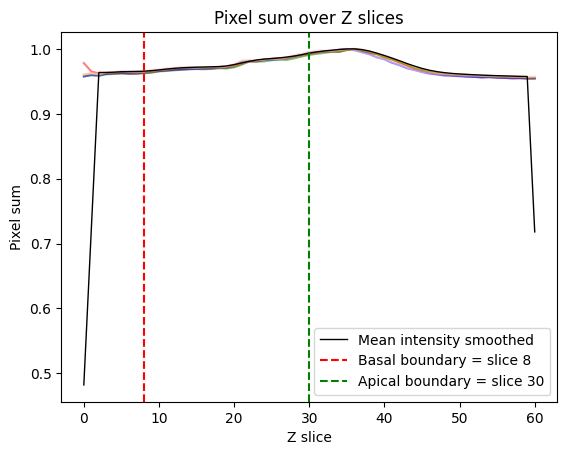

In [14]:
#channel is hard coded in the function right now. Need to allow it to be passed as a parameter by the user 
if membrane_regions_exist == True:      
    boundaries = plot_z_sum_bd(z2)

This Z axis plot shows where the max intensities are, which roughly correspond to the basal and apical regions of the cell.

The lines are the auto-detected boundaries between basal, lateral, and apical.  

If needed, you can scan through the z series in Napari below to adjust the position of these boundaries.

In [15]:
# If ychange the values of the boundaries to the ones you want to use

basal_lateral_boundary_slice_manual = []
lateral_apical_boundary_slice_manual = []

if membrane_regions_exist == True and basal_lateral_boundary_slice_manual:
    boundaries = [basal_lateral_boundary_slice_manual, lateral_apical_boundary_slice_manual]
    print('Manual basal-lateral boundary slice is:', basal_lateral_boundary_slice_manual)   
    print('Manual lateral-apical boundary slice is:', lateral_apical_boundary_slice_manual)

else:
    print('Basal-lateral boundary slice is:', boundaries[0])   
    print('Lateral-apical boundary slice is:', boundaries[1])  




Basal-lateral boundary slice is: 8
Lateral-apical boundary slice is: 30


In [16]:
if membrane_regions_exist == True: 
    allocate_membrane_regions(df = final_tracks, basal_range = [0,25] , lateral_range = [25,75], apical_range = [75,112])

else: 
    final_tracks['membrane_region'] = 'Basal'

Save tracks

In [17]:
final_tracks.to_pickle(output_directory_full)

# Visualize tracks in Napari to assess track filtering quality

In [18]:
# Create a napari viewer
viewer = napari.Viewer()

#access channel 3 only from zarr array 
dask_array = da.from_zarr(z2)

#the axis arrangement is (t,c,z,y,x)
#for the sake of improved performance only 1 channel could be imported here (if images get super large and performance issues occur)
all_channels = dask_array[:,:,:,:,:]

# # Calculate the 1st and 99th percentiles for the 10th time point
# lower_limit_1, upper_limit_1 = da.percentile(all_channels[10,0,:,:,:].ravel(), [5, 95]).compute()
# lower_limit_2, upper_limit_2 = da.percentile(all_channels[10,1,:,:,:].ravel(), [5, 95]).compute()
# lower_limit_3, upper_limit_3 = da.percentile(all_channels[10,2,:,:,:].ravel(), [5, 95]).compute()


# # Set the contrast limits

# # Add each channel as a separate image layer with its own contrast limits
# layer_raw_1 = viewer.add_image(all_channels[0], contrast_limits=[lower_limit_1, upper_limit_1], name='channel 1', colormap='yellow')
# layer_raw_2 = viewer.add_image(all_channels[1], contrast_limits=[lower_limit_2, upper_limit_2], name='channel 2', colormap = 'cyan')
# layer_raw_3 = viewer.add_image(all_channels[2], contrast_limits=[lower_limit_3, upper_limit_3], name='channel 3', colormap = 'magenta')

# Add the 4D stack to the viewer
layer_raw = viewer.add_image(all_channels, channel_axis = 1, name = ['channel 1', 'channel 2', 'channel 3'])
#other useful parameters 
#color_map = list
#contrast_limits = list of list 

track_properties = {'number_of_frames': track_df['number_of_frames'].to_numpy(), 'track_id_rand': track_df['color'].to_numpy()}

# viewer.add_tracks(track_df[["track_id", "frame", "c3_peak_z", "c3_peak_y", "c3_peak_x"]], name = 'all tracks')

tracks_layer = viewer.add_tracks(track_df[["track_id", "frame", "c3_peak_z", "c3_peak_y", "c3_peak_x"]], name = 'all tracks', properties=track_properties, color_by='track_id_rand', tail_length = 15, tail_width = 2, colormap = 'hsv')

# Add Bounding Box
layer_raw[0].bounding_box.visible = True
layer_raw[1].bounding_box.visible = True
layer_raw[2].bounding_box.visible = True


/Users/valerie/miniconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/layers/tracks/tracks.py:620: UserWarning: Previous color_by key 'track_id_rand' not present in features. Falling back to track_id
  warn(


In [19]:
#Displaying Dynamin Positive tracks only (Tracks where actin is not present)
dnm2_positive_tracks_df = final_tracks[(final_tracks['channel2_positive'] == True) & (final_tracks['channel1_positive'] == False)]
dnm2_tracks_list = dnm2_positive_tracks_df['track_id'].values
track_1 = track_df[track_df['track_id'].isin(dnm2_tracks_list)]
viewer.add_tracks(track_1[["track_id", "frame", "c3_peak_z", "c3_peak_y", "c3_peak_x"]], name = 'channel2+ tracks')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [20]:
#Displaying Actin Positive tracks only (Tracks where Dynamin is not present)
actin_positive_tracks_df = final_tracks[(final_tracks['channel2_positive'] == False) & (final_tracks['channel1_positive'] == True)]
actin_tracks_list = actin_positive_tracks_df['track_id'].values
track_2 = track_df[track_df['track_id'].isin(actin_tracks_list)]
viewer.add_tracks(track_2[["track_id", "frame", "c3_peak_z", "c3_peak_y", "c3_peak_x"]], name = 'channel1+ tracks')

<Tracks layer 'channel1+ tracks' at 0x7fcedec96890>

In [21]:
#Displaying all 3 channels positive tracks 
all_positive_tracks_df = final_tracks[(final_tracks['channel2_positive'] == True) & (final_tracks['channel1_positive'] == True)]
all_positive_tracks_list = all_positive_tracks_df['track_id'].values
track_3 = track_df[track_df['track_id'].isin(all_positive_tracks_list)]
viewer.add_tracks(track_3[["track_id", "frame","c3_peak_z", "c3_peak_y", "c3_peak_x"]], name = 'all+ tracks')

<Tracks layer 'all+ tracks' at 0x7fceb9a7f940>

In [22]:
#Displaying basal tracks 
if membrane_regions_exist == True: 
    basal_tracks_df = final_tracks[final_tracks['membrane_region'] == 'Basal']
    basal_tracks_list = basal_tracks_df['track_id'].values
    track_4 = track_df[track_df['track_id'].isin(basal_tracks_list)]
    viewer.add_tracks(track_4[["track_id", "frame","c3_peak_z", "c3_peak_y", "c3_peak_x"]], name = 'basal tracks')

In [23]:
#Displaying lateral tracks 
if membrane_regions_exist == True:
    lateral_tracks_df = final_tracks[final_tracks['membrane_region'] == 'Lateral']
    lateral_tracks_list = lateral_tracks_df['track_id'].values
    track_5 = track_df[track_df['track_id'].isin(lateral_tracks_list)]
    viewer.add_tracks(track_5[["track_id", "frame", "c3_peak_z", "c3_peak_y", "c3_peak_x"]], name = 'Lateral tracks')

In [24]:
#Displaying apical tracks 
if membrane_regions_exist == True:
    apical_tracks_df = final_tracks[final_tracks['membrane_region'] == 'Apical']
    apical_tracks_list = apical_tracks_df['track_id'].values
    track_6 = track_df[track_df['track_id'].isin(apical_tracks_list)]
    viewer.add_tracks(track_6[["track_id", "frame", "c3_peak_z", "c3_peak_y", "c3_peak_x"]], name = 'Apical tracks')

: 

### final_tracks dataframe stores tracks which are at least positive in the channel you tracked.

## Once you have performed this step and have filtered tracks  you can now use the dashboard to test performance of the pipeline and access visualisations. 

# Go to multipage_dashboard and run app.py 